# Permeation barrier model

Base model for shield permeation barrier modeling

In [85]:
import festim as F

model_barrier = F.Simulation()

In [86]:
barrier_thick = 1e-6
substrate_thick = 3e-3

barrier = F.Material(
    id=1,
    D_0=1e-8,
    E_D=0.39,
    S_0=1e22,
    E_S=1.04,
    borders=[0, barrier_thick]
    )

# tungsten
substrate = F.Material(
    id=2,
    D_0=4.1e-7,
    E_D=0.39,
    S_0=1.87e24,
    E_S=1.04,
    borders=[barrier_thick, substrate_thick + barrier_thick]
    )

model_barrier.materials = [barrier, substrate]

In [87]:
import numpy as np

vertices_barrier = np.linspace(0, barrier_thick, num=50)

vertices_substrate = np.linspace(
    barrier_thick, substrate_thick + barrier_thick, num=50)

vertices = np.concatenate([vertices_barrier, vertices_substrate])

model_barrier.mesh = F.MeshFromVertices(vertices)


In [88]:
model_barrier.T = F.Temperature(600)

In [89]:
P_up = 100

left_bc = F.SievertsBC(
    surfaces=1,
    S_0=barrier.S_0,
    E_S=barrier.E_S,
    pressure=P_up
    )

right_bc = F.DirichletBC(
    field="solute",
    surfaces=2,
    value=0
    )

model_barrier.boundary_conditions = [left_bc, right_bc]

In [90]:
times_input = [100, 17000, 8e5]

results_folder = "results"

derived_quantities_with_barrier = F.DerivedQuantities([F.HydrogenFlux(surface=2)], show_units=True)

model_barrier.exports = [
    F.XDMFExport(
        field="solute",
        filename=results_folder + "/hydrogen_concentration.xdmf",
        checkpoint=False,  # needed in 1D
    ),
    F.TXTExport(
        field="solute",
        times=times_input,
        filename=results_folder + "/mobile_concentration.txt",
    ),
    derived_quantities_with_barrier
]

In [91]:
model_barrier.settings = F.Settings(
    absolute_tolerance=1e0,
    relative_tolerance=1e-09,
    final_time=8e5,
    chemical_pot=True,
)


model_barrier.dt = F.Stepsize(
    initial_value=5,
    stepsize_change_ratio=1.1
)

In [92]:
model_barrier.initialise()
model_barrier.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        8.0e+05 s    Elapsed time so far: 0.6 s


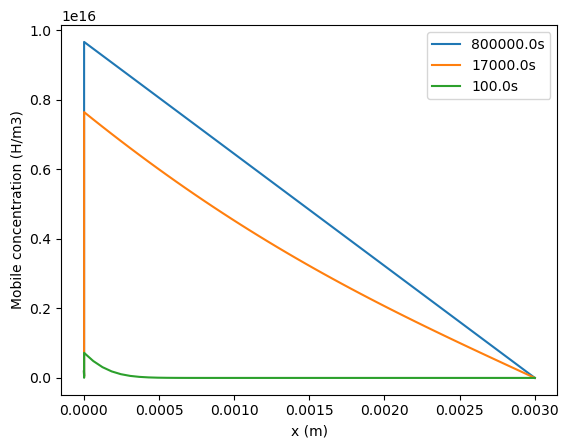

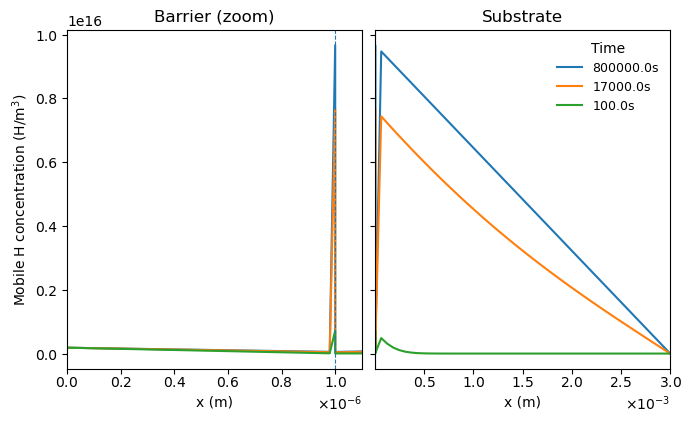

In [93]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter

data = np.genfromtxt(
    results_folder + "/mobile_concentration.txt", skip_header=1, delimiter=","
)

plt.plot(data[:, 0], data[:, 3], label=f"{float(times_input[2])}s")
plt.plot(data[:, 0], data[:, 2], label=f"{float(times_input[1])}s")
plt.plot(data[:, 0], data[:, 1], label=f"{float(times_input[0])}s")

plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.legend()
plt.show()



# Load & sort by x
data = np.genfromtxt(results_folder + "/mobile_concentration.txt",
                     skip_header=1, delimiter=",")
data = data[data[:, 0].argsort()]

x = data[:, 0]
ys   = [data[:, 3], data[:, 2], data[:, 1]]
labs = [f"{float(times_input[2])}s",
        f"{float(times_input[1])}s",
        f"{float(times_input[0])}s"]

# Taller, less-wide figure
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True,
                        figsize=(6.8, 6.2), constrained_layout=True)

# Make each axes taller than wide (fallback-safe)
for ax in axs:
    try:
        ax.set_box_aspect(1.15)
    except Exception:
        pass

# Zoom windows
xlims = [
    (0, barrier_thick * 1.1),                        # barrier
    (barrier_thick, barrier_thick + substrate_thick) # substrate
]

# Set up compact tick formatting
fmt = ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-3, 3))  # show ×10^k offset instead of long numbers

for ax, xlim in zip(axs, xlims):
    for y, lab in zip(ys, labs):
        ax.plot(x, y, label=lab)
    ax.set_xlabel("x (m)")
    ax.set_xlim(*xlim)
    ax.axvline(barrier_thick, linestyle="--", linewidth=0.8)

    # --- anti-overlap tweaks ---
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))       # adjust number of ticks
    ax.xaxis.set_major_formatter(fmt)                      # scientific offset
    ax.tick_params(axis="x", labelrotation=0, pad=1)       # label rotation if wanted

axs[0].set_title("Barrier (zoom)")
axs[1].set_title("Substrate")
axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")

# Linear y with gentle padding
y_min = min(np.nanmin(y) for y in ys)
y_max = max(np.nanmax(y) for y in ys)
pad = 0.05 * max(y_max - y_min, 1.0)
axs[0].set_ylim(y_min - pad, y_max + pad)  # sharey propagates

axs[1].legend(title="Time", loc="best", frameon=False, fontsize=9)
plt.show()

## Model without barrier

In [97]:
model_no_barrier = F.Simulation()

substrate.id = 1
substrate.borders = [0, substrate_thick]
model_no_barrier.materials = [substrate]

# new mesh
model_no_barrier.mesh = F.MeshFromVertices(np.linspace(barrier_thick, substrate_thick, num=50))

# change the solubility of the Sievert's condition
left_bc.S_0 = substrate.S_0
left_bc.E_S = substrate.E_S

model_no_barrier.T = model_barrier.T
model_no_barrier.boundary_conditions = model_barrier.boundary_conditions

model_no_barrier.settings = model_barrier.settings
model_no_barrier.settings.chemical_pot = False  # no need for chemical potential anymore

model_no_barrier.dt = model_barrier.dt

derived_quantities_without_barrier = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

model_no_barrier.exports = [derived_quantities_without_barrier]

model_no_barrier.initialise()
model_no_barrier.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        8.0e+05 s    Elapsed time so far: 0.2 s


## 3) Calculate the PRF

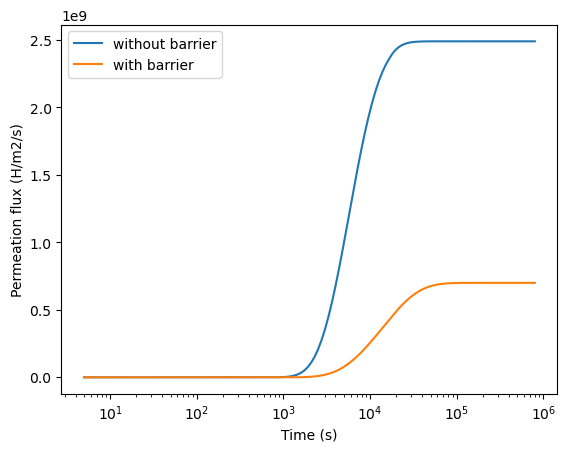

In [95]:
t_with_barrier = derived_quantities_with_barrier.t
permeation_flux_with_barrier = derived_quantities_with_barrier.filter(surfaces=2, fields="solute").data
permeation_flux_with_barrier = -np.array(permeation_flux_with_barrier)

t_without_barrier = derived_quantities_without_barrier.t
permeation_flux_no_barrier = derived_quantities_without_barrier.filter(surfaces=2, fields="solute").data
permeation_flux_no_barrier = -np.array(permeation_flux_no_barrier)

plt.figure()

plt.plot(t_without_barrier, permeation_flux_no_barrier, label="without barrier")
plt.plot(t_with_barrier, permeation_flux_with_barrier, label="with barrier")

plt.xscale("log")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Permeation flux (H/m2/s)")
plt.show()

Clearly, having the coating on both sides reduces the permeation flux!

Moreover, it can be shown that the PRF of this configuration is:

$$\mathrm{PRF} = 1 + 2 \alpha \beta \gamma$$

With 

$$\alpha = D_\mathrm{substrate} / D_\mathrm{barrier} $$

$$\beta = S_\mathrm{substrate} / S_\mathrm{barrier} $$

$$\gamma = e_\mathrm{barrier} / e_\mathrm{substrate} $$

We can compare the computed PRF to the theory.

In [96]:
computed_PRF = permeation_flux_no_barrier[-1]/permeation_flux_with_barrier[-1]

diff_ratio = substrate.D_0/barrier.D_0
sol_ratio = substrate.S_0/barrier.S_0
length_ratio = barrier_thick/substrate_thick

theoretical_PRF = 1 + 2 * diff_ratio*sol_ratio*length_ratio

print(f"Theoretical PRF = {theoretical_PRF:.4f}")
print(f"Computed PRF = {computed_PRF:.4f}")
print(f"Error = {(computed_PRF - theoretical_PRF)/theoretical_PRF:.2%}")

Theoretical PRF = 6.1113
Computed PRF = 3.5569
Error = -41.80%
